<a href="https://colab.research.google.com/github/realfolkcode/random-convex-graphs/blob/main/random_convex_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [41]:
from __future__ import print_function
from IPython.display import clear_output
import torch
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from time import time
from random import choice
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.spatial import Delaunay
from copy import copy
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#from queue import Queue

import warnings
warnings.filterwarnings("ignore")

# Embedding to graph

## Implementation

In [70]:
import random

In [71]:
def emb_to_graph(emb):
    n = emb.shape[0]
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            if np.linalg.norm(emb[i] - emb[j], ord=1) == 1:
                G.add_edge(i, j)
    return G

In [72]:
def ba_space_rect(n, d):
    # Initialize two neughboring points that lie on the same axis
    emb = np.zeros((n, d))
    emb[1][0] = 1
    free = [0, 1]
    degrees = [1, 1]
    # Mapping from coordinates to idx (if exists)
    occupied = {}
    occupied[tuple(emb[0])] = 0
    occupied[tuple(emb[1])] = 1

    i = 2
    while i < n:
        idx = np.random.choice(free, p=degrees / np.sum(degrees))
        neighbors = []
        for k in range(d):
            tmp = emb[idx].copy()
            tmp[k] -= 1
            if tuple(tmp) not in occupied:
                neighbors.append(-k)
            tmp = emb[idx].copy()
            tmp[k] += 1
            if tuple(tmp) not in occupied:
                neighbors.append(k)
        if len(neighbors) > 0:
            k = np.random.choice(neighbors)
            emb[i] = emb[idx]
            if k < 0:
                emb[i][-k] -= 1
            else:
                emb[i][k] += 1
            occupied[tuple(emb[i])] = i
            free.append(i)
            deg_i = 0
            for k in range(d):
                tmp = emb[i].copy()
                tmp[k] -= 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
                tmp = emb[i].copy()
                tmp[k] += 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
            degrees.append(deg_i)
            i += 1
    return emb

In [73]:
def add_neighbor(neighbors, occupied, x, dx):
    tmp = x.copy()
    if len(dx) == 1:
        dx = dx[0]
        tmp[abs(dx)-1] += np.sign(dx)
        if tuple(tmp) not in occupied:
            neighbors.append((dx,))
    elif len(dx) == 2:
        tmp[abs(dx[0])-1] += np.sign(dx)[0] / 2
        tmp[abs(dx[1])-1] += np.sign(dx)[1] / 2
        if tuple(tmp) not in occupied:
            neighbors.append(dx)
    return neighbors

In [74]:
def add_degree(degrees, occupied, x, dx):
    tmp = x.copy()
    if len(dx) == 1:
        dx = dx[0]
        tmp[abs(dx)-1] += np.sign(dx)
    elif len(dx) == 2:
        tmp[abs(dx[0])-1] += np.sign(dx)[0] / 2
        tmp[abs(dx[1])-1] += np.sign(dx)[1] / 2
    if tuple(tmp) in occupied:
        #print(len(degrees), occupied[tuple(tmp)], x, tmp)
        degrees[occupied[tuple(tmp)]] += 1
        return 1
    return 0

In [75]:
def ba_space(n, d):
    # Initialize two neughboring points that lie on the same axis
    emb = np.zeros((n, d))
    emb[1][0] = 1
    free = [0, 1]
    degrees = [1, 1]
    # Mapping from coordinates to idx (if exists)
    occupied = {}
    occupied[tuple(emb[0])] = 0
    occupied[tuple(emb[1])] = 1

    i = 2
    while i < n:
        idx = np.random.choice(free, p=degrees/np.sum(degrees))
        neighbors = []
        for k in range(1, d+1):
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k,))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k,))
        for k, l in combinations(range(1, d+1), 2):
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k, l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k, l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k, -l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k, -l))
        if len(neighbors) > 0:
            dx = random.choice(neighbors)
            emb[i] = emb[idx]
            if len(dx) == 1:
                dx = dx[0]
                emb[i][abs(dx)-1] += np.sign(dx)
            elif len(dx) == 2:
                emb[i][abs(dx[0])-1] += np.sign(dx[0]) / 2
                emb[i][abs(dx[1])-1] += np.sign(dx[1]) / 2
            occupied[tuple(emb[i])] = i
            free.append(i)
            deg_i = 0
            for k in range(1, d+1):
                deg_i += add_degree(degrees, occupied, emb[i], (k,))
                deg_i += add_degree(degrees, occupied, emb[i], (-k,))
            for k, l in combinations(range(1, d+1), 2):
                deg_i += add_degree(degrees, occupied, emb[i], (k, l))
                deg_i += add_degree(degrees, occupied, emb[i], (-k, l))
                deg_i += add_degree(degrees, occupied, emb[i], (k, -l))
                deg_i += add_degree(degrees, occupied, emb[i], (-k, -l))
            degrees.append(deg_i)
            #print(degrees)
            i += 1
    
    return emb

In [76]:
def plot_lin_degree_distribution(degrees):   
    rho=np.bincount(degrees)/len(degrees)
    k=np.arange(len(degrees))[np.nonzero(rho)]
    rho_k=rho[np.nonzero(rho)]

    plt.loglog()
    plt.scatter(k,rho_k)
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

In [77]:
def plot_log_degree_distribution(degrees, num_bins): 
    rho, k = np.histogram(degrees, bins=np.logspace(0, np.log10(np.max(degrees)), num_bins, endpoint=True), density=True)

    plt.scatter(k[:-1],rho)
    plt.loglog()
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

## Generate graphs

In [38]:
import os
os.makedirs('graphs')

In [39]:
np.random.seed(42)
random.seed(42)

for i in range(10):
    emb = ba_space(1000, 20)
    V = emb_to_graph(emb)
    nx.write_pajek(V, 'graphs/random_1000_20_' + str(i) + '.net')

In [40]:
!zip -r graphs.zip graphs

  adding: graphs/ (stored 0%)
  adding: graphs/random_1000_20_9.net (deflated 74%)
  adding: graphs/random_1000_20_1.net (deflated 74%)
  adding: graphs/random_1000_20_4.net (deflated 74%)
  adding: graphs/random_1000_20_7.net (deflated 74%)
  adding: graphs/random_1000_20_6.net (deflated 74%)
  adding: graphs/random_1000_20_5.net (deflated 74%)
  adding: graphs/random_1000_20_8.net (deflated 74%)
  adding: graphs/random_1000_20_3.net (deflated 74%)
  adding: graphs/random_1000_20_0.net (deflated 74%)
  adding: graphs/random_1000_20_2.net (deflated 74%)


## Statistics

In [78]:
from google.colab import files

In [79]:
files.upload()

Saving random_1000_20_0.net to random_1000_20_0.net
Saving random_1000_20_1.net to random_1000_20_1.net
Saving random_1000_20_2.net to random_1000_20_2.net
Saving random_1000_20_3.net to random_1000_20_3.net
Saving random_1000_20_4.net to random_1000_20_4.net
Saving random_1000_20_5.net to random_1000_20_5.net
Saving random_1000_20_6.net to random_1000_20_6.net
Saving random_1000_20_7.net to random_1000_20_7.net
Saving random_1000_20_8.net to random_1000_20_8.net
Saving random_1000_20_9.net to random_1000_20_9.net


{'random_1000_20_0.net': b'*vertices 1000\n1 0 0.0 0.0 ellipse\n2 1 0.0 0.0 ellipse\n3 2 0.0 0.0 ellipse\n4 3 0.0 0.0 ellipse\n5 4 0.0 0.0 ellipse\n6 5 0.0 0.0 ellipse\n7 6 0.0 0.0 ellipse\n8 7 0.0 0.0 ellipse\n9 8 0.0 0.0 ellipse\n10 9 0.0 0.0 ellipse\n11 10 0.0 0.0 ellipse\n12 11 0.0 0.0 ellipse\n13 12 0.0 0.0 ellipse\n14 13 0.0 0.0 ellipse\n15 14 0.0 0.0 ellipse\n16 15 0.0 0.0 ellipse\n17 16 0.0 0.0 ellipse\n18 17 0.0 0.0 ellipse\n19 18 0.0 0.0 ellipse\n20 19 0.0 0.0 ellipse\n21 20 0.0 0.0 ellipse\n22 21 0.0 0.0 ellipse\n23 22 0.0 0.0 ellipse\n24 23 0.0 0.0 ellipse\n25 24 0.0 0.0 ellipse\n26 25 0.0 0.0 ellipse\n27 26 0.0 0.0 ellipse\n28 27 0.0 0.0 ellipse\n29 28 0.0 0.0 ellipse\n30 29 0.0 0.0 ellipse\n31 30 0.0 0.0 ellipse\n32 31 0.0 0.0 ellipse\n33 32 0.0 0.0 ellipse\n34 33 0.0 0.0 ellipse\n35 34 0.0 0.0 ellipse\n36 35 0.0 0.0 ellipse\n37 36 0.0 0.0 ellipse\n38 37 0.0 0.0 ellipse\n39 38 0.0 0.0 ellipse\n40 39 0.0 0.0 ellipse\n41 40 0.0 0.0 ellipse\n42 41 0.0 0.0 ellipse\n43 42 0.0 

In [80]:
for i in range(10):
    V = nx.Graph(nx.read_pajek('random_1000_20_' + str(i) + '.net'))
    print(nx.average_clustering(V))

0.33797151824073435
0.3373321795116892
0.3733687754902349
0.31917502724386065
0.33214392622146743
0.3261614092599601
0.36840955240854156
0.3620834213067326
0.31882619878393553
0.31745469466517556


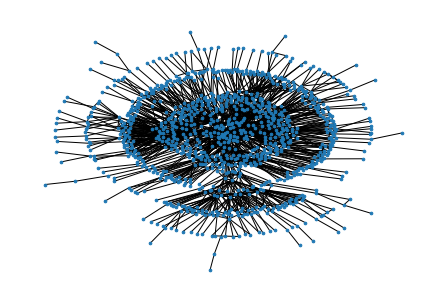

In [90]:
nx.draw_kamada_kawai(V, node_size=7)

In [82]:
degrees = [d for node, d in V.degree()]

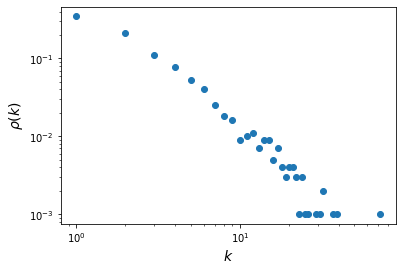

In [83]:
plot_lin_degree_distribution(degrees)

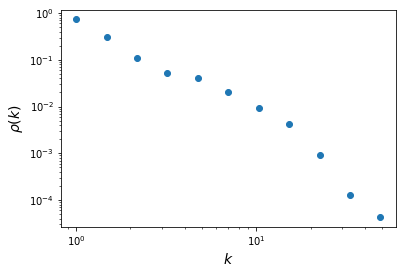

In [86]:
plot_log_degree_distribution(degrees, 12)

In [87]:
nx.average_clustering(V)

0.31745469466517556